## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt

In [2]:


class Camera():
    def __init__(self, files_name, chess_corner_cnt_column, chess_corner_cnt_row):
        # caliberation files
        self.files_name = files_name
        self.column_cnt = chess_corner_cnt_column
        self.row_cnt = chess_corner_cnt_row
        # matrix of camare caliberation
        self.mtx = []
        self.dist = []
        self.rvecs = []
        self.tvecs = []
        self.inited = True
    
    # Change camare calculate to function
    def caliberation_camera_f(self):
        '''
        calibration camare by input images (at list 20 images).
        return ret, mtx, dist, rvecs, tvecs
        '''

        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((self.column_cnt*self.row_cnt,3), np.float32)
        objp[:,:2] = np.mgrid[0:self.row_cnt,0:self.column_cnt].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.
        img_size = []

        # Step through the list and search for chessboard corners
        for fname in self.files_name:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Get img_size
            img_size = (img.shape[1], img.shape[0])
            #print(img_size)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (self.row_cnt, self.column_cnt),None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)            
                
            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (self.row_cnt,self.column_cnt), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)

        #cv2.destroyAllWindows()

        # Calibrate Camera
        ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(
            objpoints, imgpoints, img_size, None, None)

        # Return
        return ret
    
    # Undistort function to output undistort image
    def undistort_image_f(self, newImage):
        undist = cv2.undistort(newImage, self.mtx, self.dist, None, self.mtx)
        return undist

# Test class Camera
# Make a list of calibration images
if ('cameraObj' in locals().keys()) == False:
    caliberation_images = glob.glob('camera_cal/calibration*.jpg')
    camera_obj = Camera(caliberation_images, 6, 9)
    camera_obj.caliberation_camera_f()
    print("CameraObj init finished!")
else:
    print("CameraObj can't init again!")
# Make a list of calibration images
#calibration_images = glob.glob('camera_cal/calibration*.jpg')

#ret, mtx, dist = calibration_camare(calibration_images, 6, 9)

CameraObj init finished!


## Apply a distortion correction to raw images

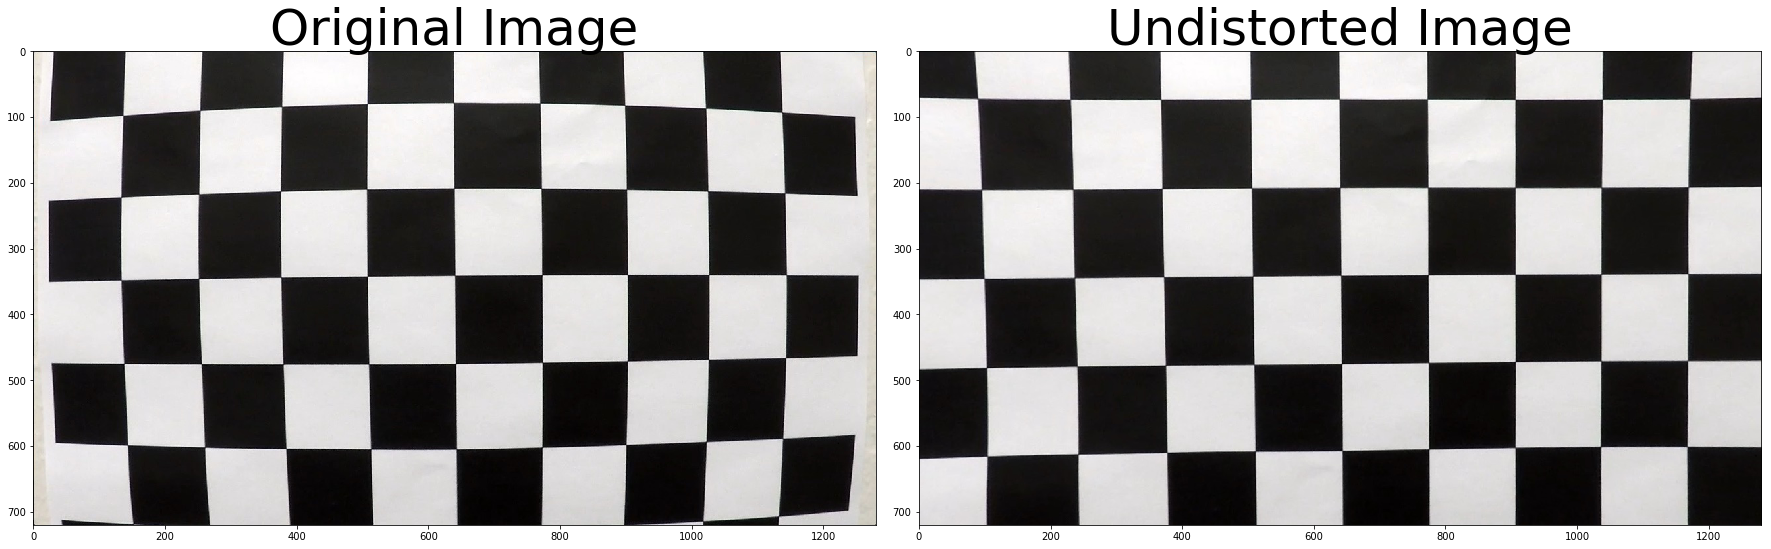

In [3]:
#chess_image = cv2.imread('./camera_cal/calibration1.jpg')
chess_image = mpimg.imread('camera_cal/calibration1.jpg')
undist_chess_image = camera_obj.undistort_image_f(chess_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(chess_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_chess_image)
ax2.set_title('Undistorted Image', fontsize=50)
plt.savefig('output_images/undistort_chessboard.jpg')
#f.imsave('output_images/undistort_chessboard.jpg')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Use color transforms, gradients, etc., to create a thresholded binary image.

6


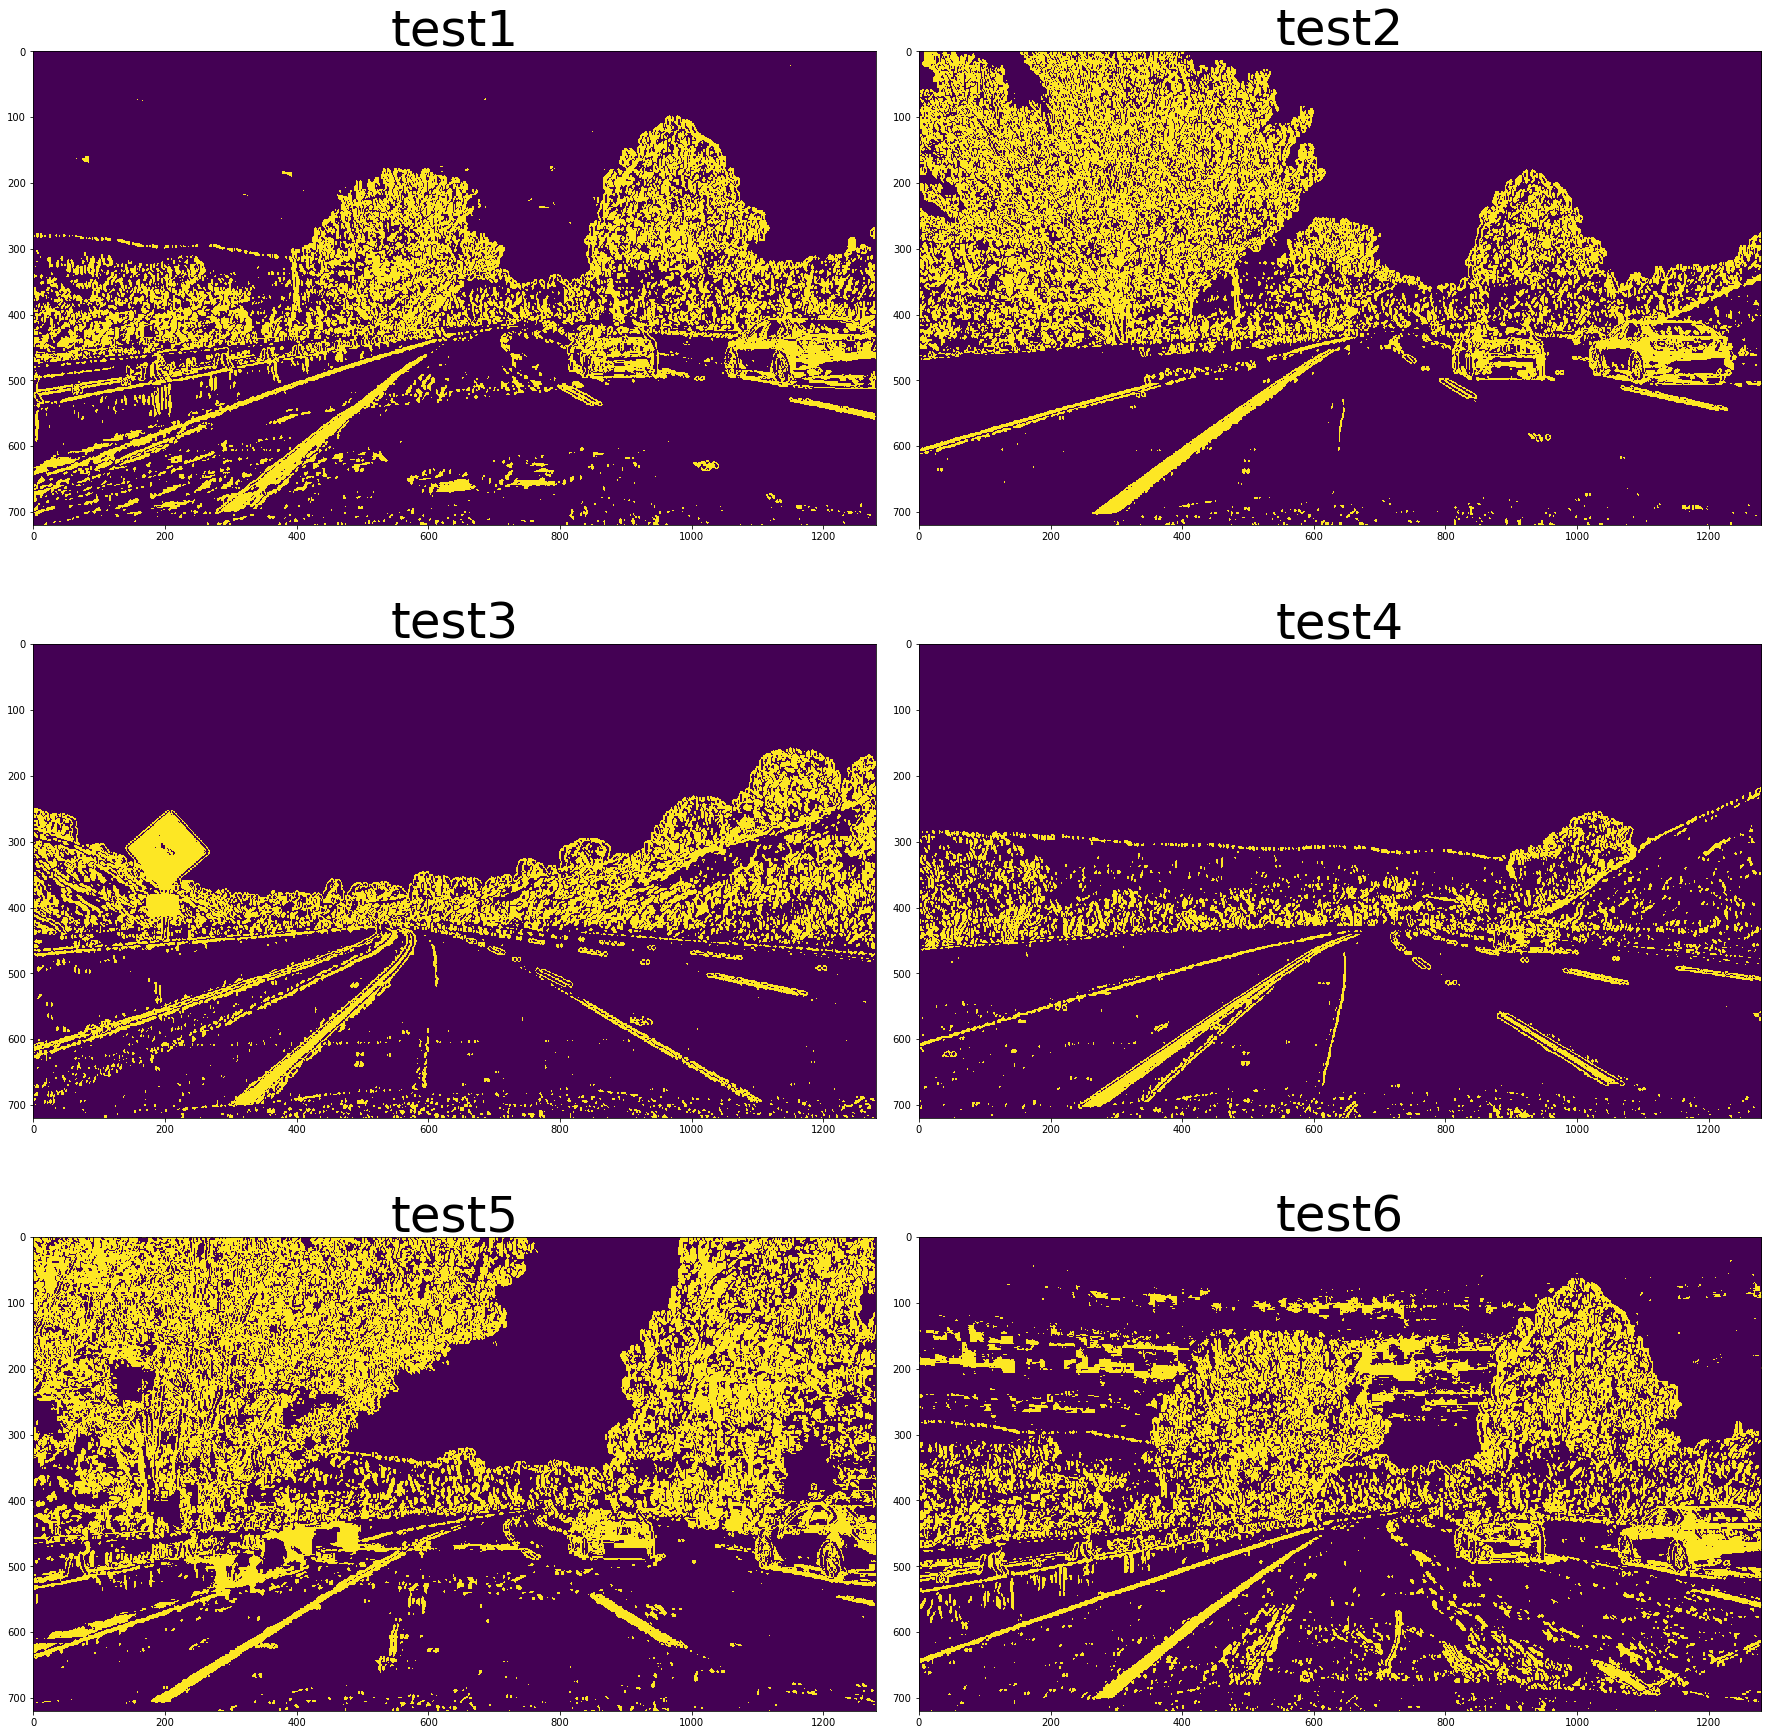

In [4]:
class BinaryImage():
    def __init__(self):
        # variants of absolute sobel 
        self.abs_sobel_threshold = (10, 70) # or (20, 100) based on test1.jpg.
        self.abs_sobel_kernel = 11
        self.abs_sobel_orient = 'x'
        
        # variants of magnitude sobel
        self.mag_sobel_threshold = (20, 70)
        self.mag_sobel_kernel = 11
        
        # variants of direction sobel
        self.dir_sobel_threshold = (0.7, 1.3) # or (0,np.pi/2)
        self.dir_sobel_kernel = 15
        
        # variant of red channel
        self.r_channel_threshold = (220, 255) # or (200, 255)
        
        # variant of saturation
        self.s_channel_threshold = (130,255)
        
    def abs_sobel_thres_f(self, gray_image):
        '''
        Do Sobel transform based on input gray image. 
        Only keep points larger than thresh_min and less than thresh_max and return.    

        gray_image: grayed image
        orient: 'x' axis-x, 'y' axis-y
        thresh_min: Keeped value should larger and equal than it
        thresh_max: Keeped value should less than it.

        After test on test1.jpg, thresh=(10,70)
        '''
        # Check need convert axis-x or axis-y for Sobel
        if self.abs_sobel_orient == 'x':
            sobel = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize = self.abs_sobel_kernel)
        else:
            sobel = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize = self.abs_sobel_kernel)

        # Scale absoluted sobel to 8 bits
        abs_sobel=np.absolute(sobel)    
        scale_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

        # Apply threshold
        binary_output = np.zeros_like(scale_sobel)
        binary_output[(scale_sobel >= self.abs_sobel_threshold[0]) &
                      (scale_sobel < self.abs_sobel_threshold[1])] = 1
        return binary_output

    def mag_sobel_thres_f(self, gray_image):
        '''
        Return magnitude sobelx and sobely. Also apply thresh and kernel     

        After test on test1.jpg, thresh=(20, 70)
        '''
        # Caculate mag_sboel based on sobelx and sobely
        sobelx=cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=self.mag_sobel_kernel)
        sobely=cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=self.mag_sobel_kernel)
        mag_sobel = np.sqrt(sobelx**2+sobely**2)

        # Change to uint8
        mag_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))

        # Convert to binary
        binary_output = np.zeros_like(mag_sobel)
        binary_output[(mag_sobel >= self.mag_sobel_threshold[0]) 
                      & (mag_sobel < self.mag_sobel_threshold[1])] = 1
        
        return binary_output

    def dir_sobel_thres_f(self, gray_image):
        '''
        Return direction processed sobel value. Also apply thresh and kernel

        After test on test1.jpg, thresh=(0.7, 1.3)
        '''
        # Caculate dir sobel based on sobelx and sobely
        sobelx=cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=self.dir_sobel_kernel)
        sobely=cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=self.dir_sobel_kernel)
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

        # Convert to binary
        binary_output = np.zeros_like(absgraddir)
        binary_output[(absgraddir >= self.dir_sobel_threshold[0]) &
                      (absgraddir < self.dir_sobel_threshold[1])] = 1

        return binary_output

    def combine_sobel_thresh_f(self, undist_image, save_name, debug_print=0):
        '''
        Combine sobelx, sobely, sobel_mag, sobel_dir based on undist_image. 
        Also apply thresh and kernel    
        '''
        gray_image = cv2.cvtColor(undist_image, cv2.COLOR_RGB2GRAY)

        # Get each type sobel value        
        sobelx_binary = self.abs_sobel_thres_f(gray_image)
        self.abs_sobel_orient = 'y'
        sobely_binary = self.abs_sobel_thres_f(gray_image)
        self.abs_sobel_orient = 'x'
        mag_sobel_binary = self.mag_sobel_thres_f(gray_image)
        dir_sobel_binary = self.dir_sobel_thres_f(gray_image) # still not clear why?

        # Combine
        combine_binary = np.zeros_like(sobelx_binary)
        combine_binary[((sobelx_binary==1)&(sobely_binary==1)) |
                       ((mag_sobel_binary==1)&(dir_sobel_binary==1))]=1

        # Draw each binary to check result
        if(debug_print == 1):
            f, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(24, 27))
            f.tight_layout()
            ax1.imshow(sobelx_binary)
            ax1.set_title('Sobel x Binary', fontsize=50)
            ax2.imshow(sobely_binary)
            ax2.set_title('Sobel y Binary', fontsize=50)
            ax3.imshow(mag_sobel_binary)
            ax3.set_title('Magnitude Binary', fontsize=50)
            ax4.imshow(dir_sobel_binary)
            ax4.set_title('Direction Binary', fontsize=50)
            ax5.imshow(combine_binary)
            ax5.set_title('Combine Binary', fontsize=50)
            ax6.imshow(gray_image)
            ax6.set_title('Original Image', fontsize=50)
            plt.savefig(save_name)    
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

        return combine_binary

    def r_channel_thres_f(self, undist_image):
        '''
        Return binary value of Red channel
        Image should be opened by mpimg.imread, RGB.

        After test on test1.jpg, thresh=(220,255)
        '''
        r_channel = undist_image[:,:,0]
        #plt.imshow(r_channel)
        #print(r_channel)
        r_binary = np.zeros_like(r_channel)
        r_binary[(r_channel > self.r_channel_threshold[0]) & (r_channel <= self.r_channel_threshold[1])] = 1

        return r_binary

    def s_channel_thres_f(self, undist_image):
        '''
        Return binary value of  channel.
        Image should be opened by mpimg.imread, RGB.

        After test on test1.jpg, thresh(130,255)
        '''
        s_channel = (cv2.cvtColor(undist_image, cv2.COLOR_RGB2HLS))[:,:,2]
        #plt.imshow(s_channel)
        #print(r_channel)
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel > self.s_channel_threshold[0]) & 
                 (s_channel <= self.s_channel_threshold[1])] = 1

        return s_binary

    def combine_sChannel_sobelX_f(self, undist_image):
        '''
        Return combined S-Channel and Sobel-X. Also apply sobel kernel
        Image should be opened by mpimg.imread, BGR.
        '''
        gray_image = cv2.cvtColor(undist_image, cv2.COLOR_RGB2GRAY)
        sobelx_binary = self.abs_sobel_thres_f(gray_image)
        #plt.imshow(sobelx_binary)

        s_binary = self.s_channel_thres_f(undist_image)

        combine_binary = np.zeros_like(s_binary)
        combine_binary[(sobelx_binary==1) | (s_binary == 1)] = 1

        return combine_binary

# Test sobel convert
# Init binaryImageObj
if ('binaryImageObj' in locals().keys()) == False:
    binaryImage_obj = BinaryImage()
else:
    print("binaryImageObj existing!")

test_binaryImage_abs_x = False # True
test_binaryImage_abs_y = False # True
test_binaryImage_mag = False # True
test_binaryImage_dir = False # True
test_binaryImage_combine_amd = False # True
test_binaryImage_s_channel = False # True
test_binaryImage_r_channel = False # True 
test_binaryImage_combine_s_absx = True

test_image = mpimg.imread('test_images/test1.jpg')
undist_test_image = camera_obj.undistort_image_f(test_image)
gray_test_image = cv2.cvtColor(undist_test_image, cv2.COLOR_RGB2GRAY)

# Test sobel absolution axis-x
if test_binaryImage_abs_x == True:
    binary_image = binaryImage_obj.abs_sobel_thres_f(gray_test_image)
    
# Test sobel absolution axis-y
if test_binaryImage_abs_y == True:
    binaryImage_obj.abs_sobel_orient = 'y'
    binary_image = binaryImage_obj.abs_sobel_thres_f(gray_test_image)
    bianryImage_obj.abs_sobel_orient = 'x'
    
# Test sobel magnitude 
if test_binaryImage_mag == True:
    binary_image = binaryImage_obj.mag_sobel_thres_f(gray_test_image)

# Test sobel directional 
if test_binaryImage_dir == True:
    binary_image = binaryImage_obj.dir_sobel_thres_f(gray_test_image)

# Test combination sobel abs + mag + dir
if test_binaryImage_combine_amd == True:
    combin_sobel_saveName = 'output_images/test1_sobel_combine.jpg'
    binary_image = binaryImage_obj.combine_sobel_thresh_f(undist_test_image, 
                                                         combin_sobel_saveName)
# test s_channel
if test_binaryImage_s_channel == True:
    binary_image = binaryImage_obj.s_channel_thres_f(undist_test_image)

# test r channel
if test_binaryImage_r_channel == True:
    binary_image = binaryImage_obj.r_channel_thres_f(undist_test_image)
    
# show image
if (test_binaryImage_abs_x == True) | (test_binaryImage_abs_y == True) |\
    (test_binaryImage_mag == True) | (test_binaryImage_dir == True) |\
    (test_binaryImage_combine_amd == True)|(test_binaryImage_s_channel == True) |\
    (test_binaryImage_r_channel == True):
    plt.imshow(binary_image)

# Sobel and S channel combine test
if test_binaryImage_combine_s_absx == True:
    test_images = glob.glob('test_images/test*.jpg')
    sobelX_sChannel_binary = []
    combine_image_num = 0
    for fname in test_images:
        # Read image and get combine binary
        image = mpimg.imread(fname)
        undist_image = camera_obj.undistort_image_f(image)
        binary = binaryImage_obj.combine_sChannel_sobelX_f(undist_image)
        sobelX_sChannel_binary.append(binary)
        combine_image_num += 1
    print(combine_image_num)
    if combine_image_num == 6:
        f, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(24, 27))
        f.tight_layout()
        ax1.imshow(sobelX_sChannel_binary[0])
        ax1.set_title('test1', fontsize=50)
        ax2.imshow(sobelX_sChannel_binary[1])
        ax2.set_title('test2', fontsize=50)
        ax3.imshow(sobelX_sChannel_binary[2])
        ax3.set_title('test3', fontsize=50)
        ax4.imshow(sobelX_sChannel_binary[3])
        ax4.set_title('test4', fontsize=50)
        ax5.imshow(sobelX_sChannel_binary[4])
        ax5.set_title('test5', fontsize=50)
        ax6.imshow(sobelX_sChannel_binary[5])
        ax6.set_title('test6', fontsize=50)
        plt.savefig('output_images/Combine_sobelX_sChannel.jpg')    
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Apply a perspective transform to rectify binary image ("birds-eye view").

viewTransform_obj created! Then delete it and recreate


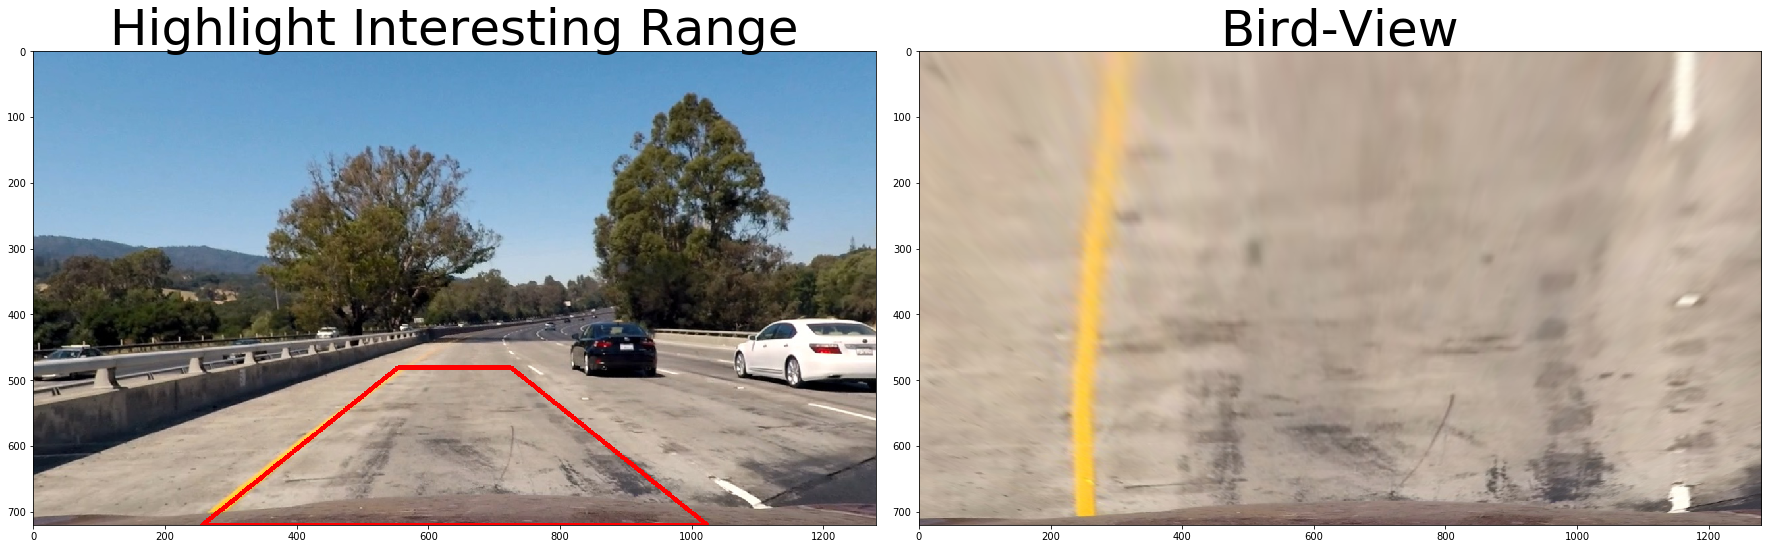

In [11]:
class ViewTransform():
    def __init__(self):
        # variants of draw retangle of interesting range
        self.draw_retangle_color = [255, 0, 0]  # Red
        self.draw_retangle_thickness = 6
        
        # variants of interesting range
        self.vertices = np.array([[]], dtype=np.int32)
        self.center_point = (0, 0)
        self.miniY = 0
        
        # view vartices
        self.eyeview_vertices = np.array([], dtype=np.int32)
        self.topview_vertices = np.array([], dtype=np.int32)
    def __del__(self):
        return
        
    def draw_retangle_of_interesting_range_f(self, image, retangle):
        # Draw Lines of retangle
        #print("retangle",retangle, "retangle[0,0]", retangle[0,0], retangle[0,1])
        cv2.line(image, (retangle[0, 0], retangle[0, 1]), (retangle[1, 0], retangle[1, 1]), 
                 self.draw_retangle_color, self.draw_retangle_thickness)
        cv2.line(image, (retangle[1, 0], retangle[1, 1]), (retangle[2, 0], retangle[2, 1]), 
                 self.draw_retangle_color, self.draw_retangle_thickness)
        cv2.line(image, (retangle[2, 0], retangle[2, 1]), (retangle[3, 0], retangle[3, 1]), 
                 self.draw_retangle_color, self.draw_retangle_thickness)
        cv2.line(image, (retangle[3, 0], retangle[3, 1]), (retangle[0, 0], retangle[0, 1]), 
                 self.draw_retangle_color, self.draw_retangle_thickness)
        return image

    def region_of_interest_f(self, img):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        `vertices` should be a numpy array of integer points.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, self.vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def set_interesting_range_of_image_f(self, img):
        '''
        Return interesting range of a image. The interesting range is identified by center_point and miniY.
        miniY must larger than axis-y of center_point
        vertices point order: leftBottom, leftTop, rightTop, rightBottom
        '''    
        if self.miniY < self.center_point[1]:
            return False, np.array([[0]], dtype=np.int32)
        imshape = img.shape

        # set interesting region   
        maxY = imshape[0]    
        left_slope = (self.center_point[1] - imshape[0])/(self.center_point[0] - 0)
        leftB = self.center_point[1] - (left_slope * self.center_point[0])
        right_slope = (imshape[0] - self.center_point[1])/(imshape[1] - self.center_point[0])
        rightB = self.center_point[1] - (right_slope * self.center_point[0])

        left_topx = np.int32((self.miniY - leftB)/left_slope)
        right_topx = np.int32((self.miniY - rightB)/right_slope)
        #print(left_topx, right_topx)
        self.vertices = np.array([[(0,maxY),(left_topx, self.miniY), (right_topx, self.miniY), 
                              (imshape[1], maxY)]], dtype=np.int32)

        return True

    def set_center_point_f(self, image_argv, x_ratio=0.5, y_ratio=(4/7)):
        self.center_point = np.uint32([image_argv.shape[1]*x_ratio, image_argv.shape[0]*y_ratio])
        return self.center_point
    
    def set_minimal_y_f(self, image_argv, miniY_ratio=(2/3)):
        self.miniY = np.uint32(image_argv.shape[0]*miniY_ratio)
        return self.miniY

    def cvt_interesting_range_2_topview_retangle_f(self, imshape):
        vertices_2d = self.vertices[0]    
        #print("2d vertices", vertices_2d)
        topviewBottomLeftX = np.int32((imshape[1]/10)*2)
        topviewBottomRightX = imshape[1] - topviewBottomLeftX

        eyeviewTopXs = []
        vertices_hs = np.dstack(vertices_2d)    
        #print("vertices_hs[0]",vertices_hs[0,0])
        for x in vertices_hs[0,0]:
            if(x > 0) & (x<imshape[1]):
                eyeviewTopXs.append(x)   
        #print("eyeviewTopXs", eyeviewTopXs)
        eyeviewTopLineLen = np.absolute(eyeviewTopXs[0]- eyeviewTopXs[1])
        #print("eyeviewTopLineLen", eyeviewTopLineLen)

        eyeviewTopLeftX = vertices_2d[1,0] + np.int32((eyeviewTopLineLen/10)*2)
        eyeviewTopRightX = vertices_2d[2, 0] - np.int32((eyeviewTopLineLen/10)*2)
        eyeviewBottomLeftX = topviewBottomLeftX
        eyeviewBottomRightX = topviewBottomRightX
        #print("vertices_2d[0,1]",vertices_2d[0,1], "vertices_2d", vertices_2d)
        #print("eyeviewTopLeftX", eyeviewTopLeftX, "eyeviewTopRightX", eyeviewTopRightX )

        self.eyeview_vertices = np.array([(eyeviewBottomLeftX, imshape[0]), (eyeviewTopLeftX, vertices_2d[1,1]),
                                   (eyeviewTopRightX, vertices_2d[2,1]), (eyeviewBottomRightX, imshape[0])])
        self.topview_vertices = np.array([(topviewBottomLeftX, imshape[0]), (topviewBottomLeftX, 0),
                                   (topviewBottomRightX, 0), (topviewBottomRightX, imshape[0])])

        return self.eyeview_vertices, self.topview_vertices

    def bird_view_transform_f(self, image_argv, original_retangle, target_retangle):
        '''
        Generate bird-view image    
        '''
        # Swrap image
        src = np.float32([original_retangle[0], original_retangle[1], 
                          original_retangle[2], original_retangle[3]])
        dst = np.float32([target_retangle[0], target_retangle[1], 
                          target_retangle[2], target_retangle[3]])
        tran_matrix = cv2.getPerspectiveTransform(src, dst)
        birdview_image = cv2.warpPerspective(image_argv, tran_matrix, 
                                             (image_argv.shape[1], image_argv.shape[0]),\
                                             flags=cv2.INTER_LINEAR)
        return birdview_image

    def test_bird_view_with_interesting_rang_f(self, camera_obj_argv, image_name, drawInterestingRange=False):
        testImage = mpimg.imread(image_name)

        undistImage = camera_obj_argv.undistort_image_f(testImage)
        imageShape = undistImage.shape

        centerPoint = self.set_center_point_f(undistImage)
        miniY = self.set_minimal_y_f(undistImage)
        #print(centerPoint, miniY)

        ret  = self.set_interesting_range_of_image_f(undistImage)
        if ret == True:
            #print("vertices", vertices)
            masked_edges = self.region_of_interest_f(undistImage)
            #plt.imshow(masked_edges)
        else: 
            print("Center point and miniY mismatch")

        eyeview_vertices, birdview_vertices = self.cvt_interesting_range_2_topview_retangle_f(
                                                        undistImage.shape)
        #print("eyeviewVertices",eyeviewVertices, "birdViewVertices",birdViewVertices)

        birdview_image = self.bird_view_transform_f(undistImage, eyeview_vertices, birdview_vertices)
        #plt.imshow(birdview_image)

        if drawInterestingRange == True:
            undistImage = self.draw_retangle_of_interesting_range_f(undistImage, eyeview_vertices)
            #birdViewImage = draw_retangle_of_interesting_range_f(birdViewImage, birdview_vertices)    

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(undistImage)
        ax1.set_title('Highlight Interesting Range', fontsize=50)
        ax2.imshow(birdview_image)
        ax2.set_title('Bird-View', fontsize=50)
        plt.savefig('output_images/bird-eyes-view.jpg')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if ('viewTransform_obj' in locals().keys()) == False:
    viewTransform_obj = ViewTransform()    
else:
    print("viewTransform_obj created! Then delete it and recreate")
    del viewTransform_obj
    viewTransform_obj = ViewTransform()
viewTransform_obj.test_bird_view_with_interesting_rang_f(camera_obj, 'test_images/test1.jpg', True)

## Detect lane pixels and fit to find the lane boundary.

In [ ]:
def 

## Determine the curvature of the lane and vehicle position with respect to center.

## Warp the detected lane boundaries back onto the original image.

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.